In [1]:
import pandas as pd


In [2]:
churn_risk_df = pd.read_csv("../data/exports/churn_risk_table.csv")
cohort_churn_df = pd.read_csv("../data/exports/cohort_churn.csv")
cohort_income_ratio_df = pd.read_csv("../data/exports/cohort_income_ratio.csv")
customer_features_df = pd.read_csv("../data/exports/customer_feature_view.csv")
rolling_avg_df = pd.read_csv("../data/exports/rolling_avg_3mo.csv")
loan_data_df = pd.read_csv("../data/exports/loan_data.csv")


C:\Users\mahas\AppData\Local\Temp\ipykernel_4936\3401109196.py:6: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_df = pd.read_csv("../data/exports/loan_data.csv")


In [3]:
churn_risk_df.head()


,customer_id,issue_date,last_payment_date,loan_status,inactive_months,tenure_months,churn_flag
0,21101,2011-11-01,2014-02-01,Fully Paid,137.0,27.0,1
1,7401,2015-10-01,2018-07-01,Fully Paid,84.0,33.0,1
2,7402,2015-11-01,2017-04-01,Fully Paid,99.0,17.0,1
3,7403,2015-11-01,2018-09-01,Fully Paid,82.0,34.0,1
4,7404,2015-11-01,2018-11-01,Fully Paid,80.0,36.0,1


In [4]:
# Probability of Default
total_customers = len(churn_risk_df)
defaulted_customers = len(churn_risk_df[churn_risk_df['loan_status'] == 'Default'])
pd_rate = defaulted_customers / total_customers
print(f"Probability of Default (PD): {pd_rate:.2%}")


Probability of Default (PD): 0.00%


In [5]:
#Loss Given Default
defaulted_loans_df = loan_data_df[loan_data_df['loan_default'] == 1].copy()
defaulted_loans_df.loc[:, 'LGD'] = (
    (defaulted_loans_df['loan_amnt'] - defaulted_loans_df['recoveries']) 
    / defaulted_loans_df['loan_amnt']
)

loan_data_df = loan_data_df.merge(
    defaulted_loans_df[['customer_id', 'LGD']], on='customer_id', how='left'
)
avg_lgd = defaulted_loans_df['LGD'].mean()

print(f"Loss Given Default (LGD): {avg_lgd:.2%}")


Loss Given Default (LGD): 92.47%


In [6]:
#LGD Group by Product Segment
defaulted_loans_df.groupby('product_segment')['LGD'].mean()



product_segment
Debt                 0.924602
Home/Health Spend    0.924407
Investment           0.927302
Other                0.924819
Name: LGD, dtype: float64

In [7]:
#LGD Group by Income Group
defaulted_loans_df.groupby('income_group')['LGD'].mean()

income_group
High         0.919513
Low          0.932843
Mid          0.925556
Upper-Mid    0.917695
Name: LGD, dtype: float64

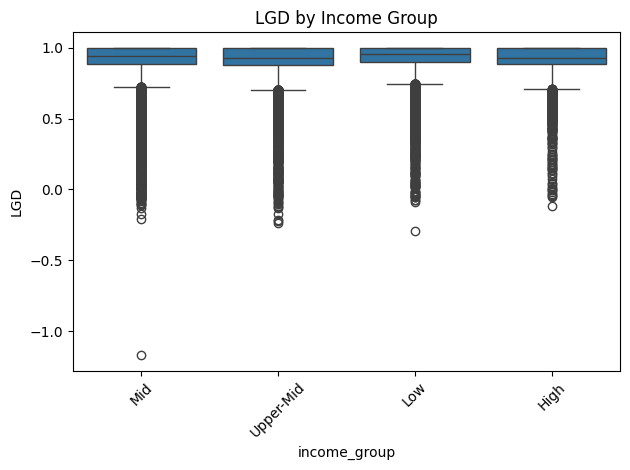

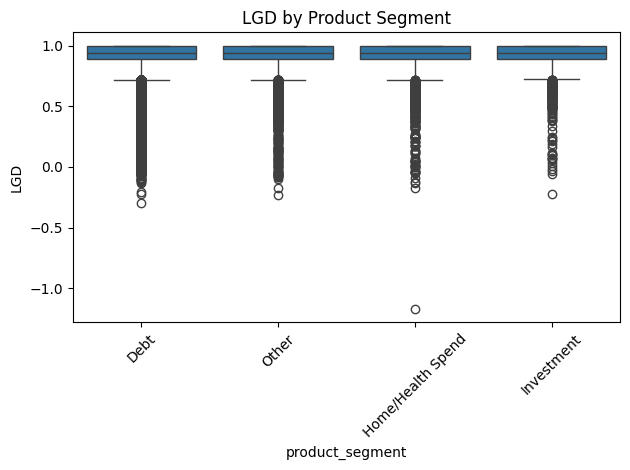

In [70]:
#visualize
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=defaulted_loans_df, x='income_group', y='LGD')
plt.title("LGD by Income Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/lgd_analysis_income_plot.png", dpi=300)
plt.show()

sns.boxplot(data=defaulted_loans_df, x='product_segment', y='LGD')
plt.title("LGD by Product Segment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/lgd_analysis_product_segment.png", dpi=300)
plt.show()

In [9]:
# Expected Credit Loss

defaulted_loans_df = loan_data_df[loan_data_df['loan_default'] == 1].copy()

defaulted_loans_df['ECL'] = (
    defaulted_loans_df['default_probability'] * 
    defaulted_loans_df['LGD'] * 
    defaulted_loans_df['loan_amnt']
)

loan_data_df = loan_data_df.merge(
    defaulted_loans_df[['customer_id','ECL']], on='customer_id', how='left'
)

avg_ecl = defaulted_loans_df['ECL'].mean()
print(f"Average Expected Credit Loss (ECL): ${avg_ecl:,.2f}")
display(defaulted_loans_df[['customer_id', 'LGD', 'ECL']].head())

Average Expected Credit Loss (ECL): $12,919.82


,customer_id,LGD,ECL
7,8,1.000000,13500.000
15,16,1.000000,9697.500
18,19,0.675373,12156.705
19,20,0.899148,14566.203
24,25,0.901211,15694.596


In [10]:
# Drop conflicting columns
loan_data_df = loan_data_df.drop(columns=[col for col in loan_data_df.columns if col in ['LGD', 'ECL']], errors='ignore')

# Merge LGD and ECL from defaulted loans only
loan_data_df = loan_data_df.merge(
    defaulted_loans_df[['customer_id', 'LGD', 'ECL']],
    on='customer_id',
    how='left'
)


In [11]:
# ECL by income group
ecl_by_income = defaulted_loans_df.groupby('income_group')['ECL'].mean()
print(ecl_by_income)

# ECL by product segment
ecl_by_segment = defaulted_loans_df.groupby('product_segment')['ECL'].mean()
print(ecl_by_segment)


income_group
High         20614.062334
Low           7395.863947
Mid          12179.708120
Upper-Mid    17125.441518
Name: ECL, dtype: float64
product_segment
Debt                 13225.994608
Home/Health Spend    13235.684932
Investment           12539.978283
Other                10103.024452
Name: ECL, dtype: float64


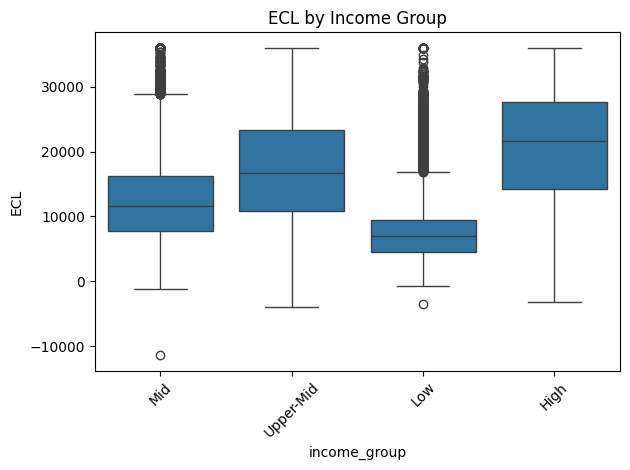

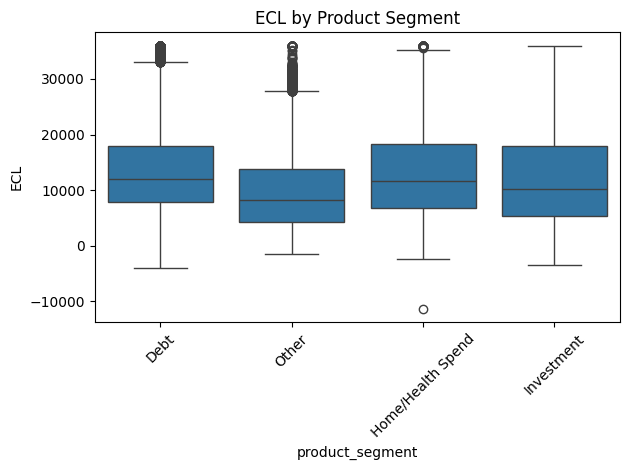

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=defaulted_loans_df, x='income_group', y='ECL')
plt.title("ECL by Income Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/ecl_analysis_income_group.png", dpi=300)
plt.show()

sns.boxplot(data=defaulted_loans_df, x='product_segment', y='ECL')
plt.title("ECL by Product Segment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/ecl_analysis_product_segment.png", dpi=300)
plt.show()

In [13]:
#Lifetime Value
ltv_df = loan_data_df.copy()

# If not already present, merge with churn info
ltv_df = ltv_df.merge(churn_risk_df[['customer_id', 'churn_flag']], on='customer_id', how='left')

# Fill NaNs in churn_flag with 0 (assume retained if not churned)
ltv_df['churn_flag'] = ltv_df['churn_flag'].fillna(0)

# Invert churn flag to get retention probability
ltv_df['retention_prob'] = 1 - ltv_df['churn_flag']

ltv_df['LTV'] = (
    ltv_df['installment'] *
    ltv_df['customer_tenure'] *  
    ltv_df['retention_prob']
)

# View the average LTV
print(f"Average LTV: ${ltv_df['LTV'].mean():,.2f}")




Average LTV: $85.65


In [14]:
# LTV by income group
print(ltv_df.groupby('income_group')['LTV'].mean())

# LTV by product segment
print(ltv_df.groupby('product_segment')['LTV'].mean())


income_group
High         158.328258
Low           65.901725
Mid           69.960766
Upper-Mid    107.443853
Name: LTV, dtype: float64
product_segment
Debt                  66.633239
Home/Health Spend    162.971691
Investment           234.236658
Other                162.215257
Name: LTV, dtype: float64


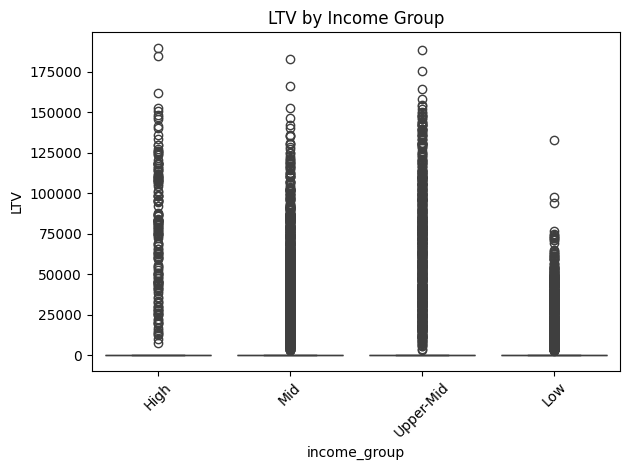

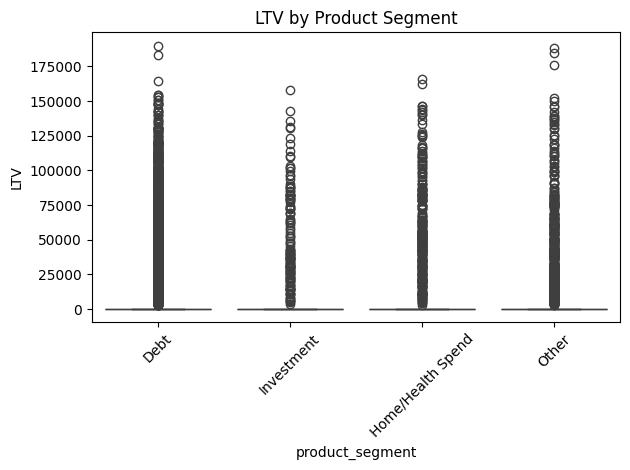

In [73]:
sns.boxplot(data=ltv_df, x='income_group', y='LTV')
plt.title("LTV by Income Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/ltv_analysis_income_group.png", dpi=300)
plt.show()

sns.boxplot(data=ltv_df, x='product_segment', y='LTV')
plt.title("LTV by Product Segment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/ltv_analysis_product_segment.png", dpi=300)
plt.show()


In [16]:
#Churn Rate
churn_rate = churn_risk_df['churn_flag'].mean()
print(f"Overall Churn Rate: {churn_rate:.2%}")

# Merge churn info with customer metadata
churn_df = churn_risk_df.merge(loan_data_df[['customer_id', 'income_group', 'product_segment']], on='customer_id', how='left')

# Grouped churn rate
grouped_churn = churn_df.groupby('income_group')['churn_flag'].mean()
print("Churn Rate by Income Group:\n", grouped_churn)

grouped_churn_product = churn_df.groupby('product_segment')['churn_flag'].mean()
print("Churn Rate by Product Segment:\n", grouped_churn_product)


Overall Churn Rate: 99.83%
Churn Rate by Income Group:
 income_group
High         0.997945
Low          0.997623
Mid          0.998482
Upper-Mid    0.998366
Name: churn_flag, dtype: float64
Churn Rate by Product Segment:
 product_segment
Debt                 0.998696
Home/Health Spend    0.997074
Investment           0.995446
Other                0.996119
Name: churn_flag, dtype: float64


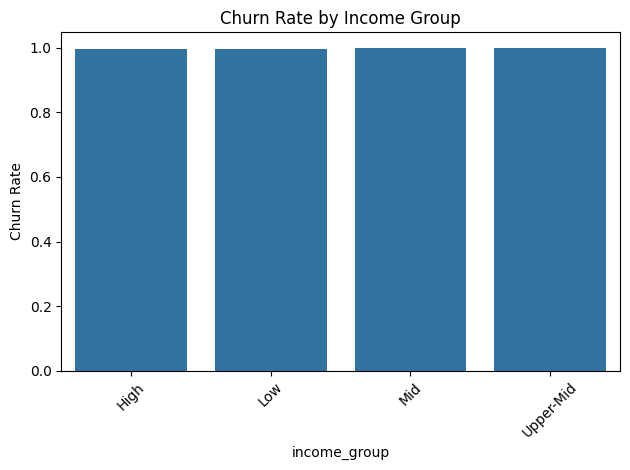

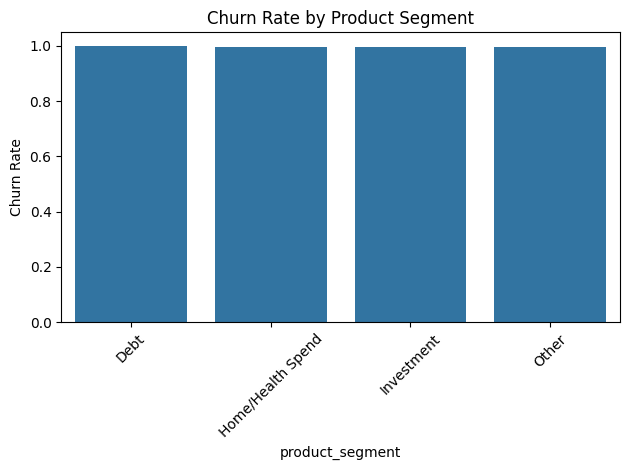

In [74]:
sns.barplot(x=grouped_churn.index, y=grouped_churn.values)
plt.title("Churn Rate by Income Group")
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/churn_rate_analysis_income_group.png", dpi=300)
plt.show()

sns.barplot(x=grouped_churn_product.index, y=grouped_churn_product.values)
plt.title("Churn Rate by Product Segment")
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/churn_rate_analysis_product_segment.png", dpi=300)
plt.show()

In [18]:
def generate_churn_scorecard(df, segment_col):
    """
    Generates a scorecard showing Churn Rate, Avg LTV, LGD, and ECL per segment.
    
    Parameters:
    df: Merged DataFrame with columns:
        - 'churn_flag'
        - 'LTV'
        - 'LGD'
        - 'ECL'
        - segment_col: column to group by (e.g. 'income_group', 'product_segment')
    
    Returns:
    Pandas DataFrame showing the churn scorecard per segment.
    """
    scorecard = df.groupby(segment_col).agg(
        Churn_Rate=('churn_flag', 'mean'),
        Avg_LTV=('LTV', 'mean'),
        Avg_LGD=('LGD', 'mean'),
        Avg_ECL=('ECL', 'mean'),
        Customers=('customer_id', 'nunique')
    ).sort_values('Churn_Rate', ascending=False)

    # Format as percentages
    scorecard['Churn_Rate'] = scorecard['Churn_Rate'] * 100
    scorecard['Avg_LGD'] = scorecard['Avg_LGD'] * 100
    scorecard['Avg_ECL'] = scorecard['Avg_ECL'] * 100

    return scorecard.round(2)


In [19]:
# Check a few defaulted loans
loan_data_df[loan_data_df['loan_default'] == 1][['customer_id', 'loan_amnt', 'recoveries', 'LGD', 'ECL']].head()


,customer_id,loan_amnt,recoveries,LGD,ECL
7,8,15000,0.00,1.000000,13500.000
15,16,10775,0.00,1.000000,9697.500
18,19,20000,6492.55,0.675373,12156.705
19,20,18000,1815.33,0.899148,14566.203
24,25,19350,1911.56,0.901211,15694.596


In [20]:
# Start fresh by creating metrics_df from loan_data_df
metrics_df = loan_data_df[[
    'customer_id',
    'LGD',
    'ECL',
]].copy()

# Drop any duplicate rows if needed
metrics_df = metrics_df.drop_duplicates(subset='customer_id')


In [21]:
#  Drop any conflicting LGD or ECL columns from metrics_df
metrics_df = metrics_df.drop(
    columns=[col for col in metrics_df.columns if col in ['LGD', 'LGD_x', 'LGD_y', 'ECL', 'ECL_x', 'ECL_y']],
    errors='ignore'
)

# Merge LGD from defaulted_loans_df
if 'LGD' in defaulted_loans_df.columns:
    metrics_df = metrics_df.merge(
        defaulted_loans_df[['customer_id', 'LGD']],
        on='customer_id',
        how='left'
    )

# Merge ECL from loan_data_df
if 'ECL' in loan_data_df.columns:
    metrics_df = metrics_df.merge(
        loan_data_df[['customer_id', 'ECL']],
        on='customer_id',
        how='left'
    )

# Preview the updated metrics_df
display(metrics_df[['customer_id', 'LGD', 'ECL']].dropna().head())


,customer_id,LGD,ECL
7,8,1.000000,13500.000
15,16,1.000000,9697.500
18,19,0.675373,12156.705
19,20,0.899148,14566.203
24,25,0.901211,15694.596


In [22]:
print("Final shape:", metrics_df.shape)
print("Sample rows with all KPIs:\n")



Final shape: (1345350, 3)
Sample rows with all KPIs:



In [23]:
# Extract numeric loan term in months
loan_data_df['term_months'] = loan_data_df['term'].str.extract(r'(\d+)').astype(int)

# Approximate total interest received
# Formula: (monthly installment * number of months) - principal loan amount
loan_data_df['interest_received'] = (loan_data_df['installment'] * loan_data_df['term_months']) - loan_data_df['loan_amnt']

# Preview for validation
loan_data_df[['customer_id', 'loan_amnt', 'installment', 'term_months', 'interest_received']].head()

# Filter active (non-defaulted) customers
active_customers_df = loan_data_df[loan_data_df['loan_default'] == 0].copy()

# Total interest-based revenue from active customers
total_revenue = active_customers_df['interest_received'].sum()

# Unique active users
active_user_count = active_customers_df['customer_id'].nunique()

# Average Revenue Per User (ARPU)
arpu = total_revenue / active_user_count

print(f"ARPU (Average Revenue Per User): ${arpu:,.2f}")



ARPU (Average Revenue Per User): $3,831.40


In [24]:
# Calculate ARPU = total payments / tenure
arpu_df = loan_data_df[['customer_id', 'total_pymnt', 'customer_tenure']].copy()
arpu_df['ARPU'] = arpu_df['total_pymnt'] / arpu_df['customer_tenure']


In [25]:
# Merge ARPU from arpu_df
if 'ARPU' in arpu_df.columns:
    metrics_df = metrics_df.merge(
        arpu_df[['customer_id', 'ARPU']],
        on='customer_id',
        how='left'
    )


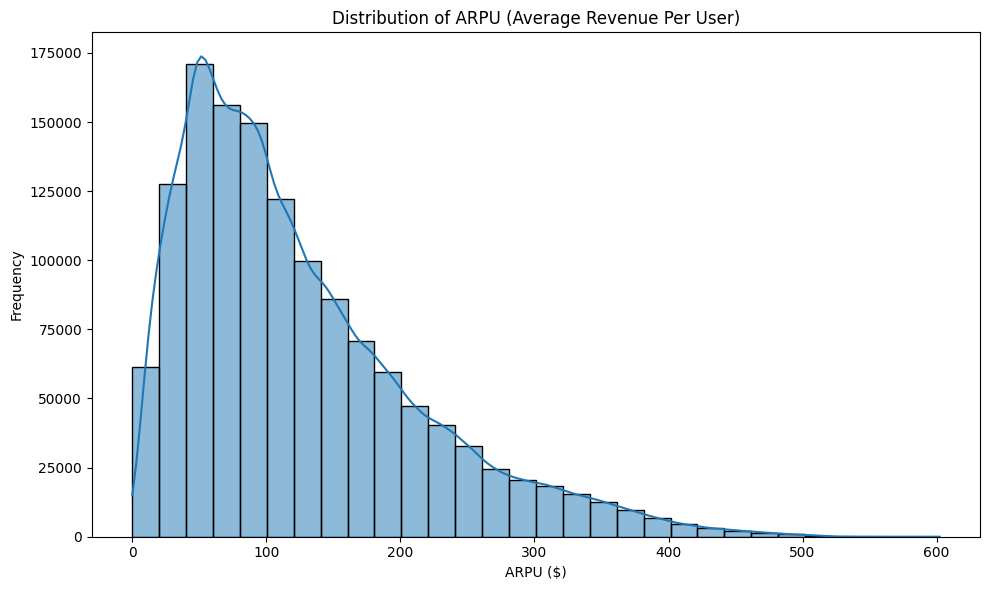

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(metrics_df['ARPU'].dropna(), kde=True, bins=30)
plt.title('Distribution of ARPU (Average Revenue Per User)')
plt.xlabel('ARPU ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("../outputs/Average_Revenue_Per_User.png", dpi=300)
plt.show()


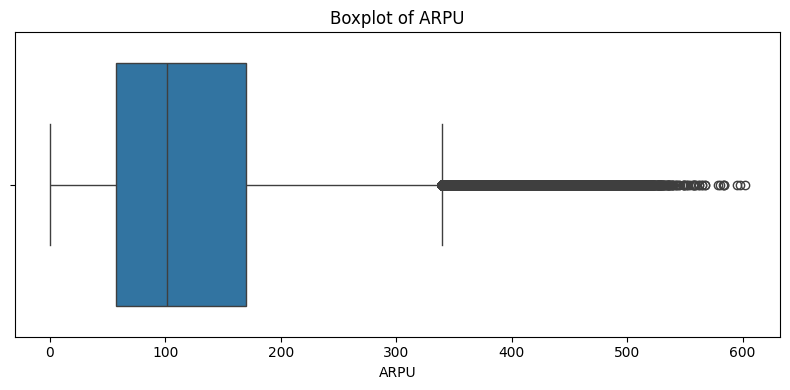

In [76]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=metrics_df['ARPU'])
plt.title('Boxplot of ARPU')
plt.tight_layout()
plt.savefig("../outputs/boxplot_ARPU.png", dpi=300)
plt.show()


In [28]:
#  Confirm 'term' exists in loan_data_df
print("'term' in loan_data_df:", 'term' in loan_data_df.columns)
print("loan_data_df columns:", loan_data_df.columns.tolist())

# Merge only if column exists
if 'term' in loan_data_df.columns:
    # Only keep 'customer_id' and 'term'
    term_df = loan_data_df[['customer_id', 'term']].dropna(subset=['term'])

    # Debug before merge
    print("Sample term values before merge:\n", term_df['term'].unique()[:5])

    # Merge into metrics_df
    metrics_df = metrics_df.merge(term_df, on='customer_id', how='left')

    # Confirm the merge result
    print("After merge, 'term' in metrics_df:", 'term' in metrics_df.columns)
    print("Null term values after merge:", metrics_df['term'].isnull().sum())
else:
    print("ERROR: 'term' column missing in loan_data_df.")


'term' in loan_data_df: True
loan_data_df columns: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'o

CLTV calculation complete.
Sample rows:
         customer_id       ARPU  term         CLTV
959338       959339  42.374485  36.0  1525.481475
959321       959322   6.598935  36.0   237.561667
959329       959330  26.627456  36.0   958.588422
959328       959329  26.138691  36.0   940.992873
959316       959317  25.896475  36.0   932.273088


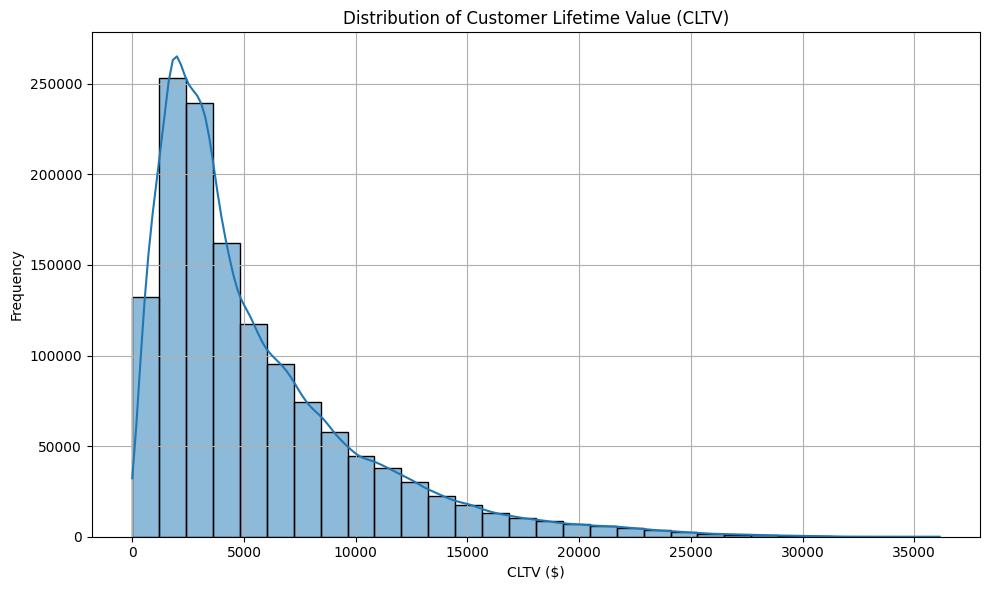

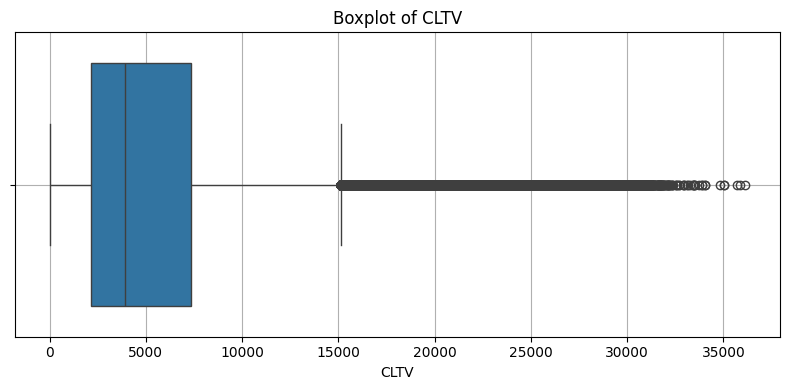

In [77]:

# Extract numeric loan term (in months)

metrics_df['term'] = (
    metrics_df['term'].astype(str)
    .str.extract(r'(\d+)')[0]   # Extract only digits
    .astype(float)              # Convert to float
)


# Compute CLTV = ARPU * term

metrics_df['CLTV'] = metrics_df['ARPU'] * metrics_df['term']



print("CLTV calculation complete.")
print("Sample rows:\n", metrics_df[['customer_id', 'ARPU', 'term', 'CLTV']].dropna().head())


# CLTV Histogram

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(metrics_df['CLTV'].dropna(), kde=True, bins=30)
plt.title('Distribution of Customer Lifetime Value (CLTV)')
plt.xlabel('CLTV ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/cltv.png", dpi=300)
plt.show()


#  CLTV Boxplot

plt.figure(figsize=(8, 4))
sns.boxplot(x=metrics_df['CLTV'].dropna())
plt.title('Boxplot of CLTV')
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/cltv_boxplot.png", dpi=300)
plt.show()



In [30]:
metrics_df = metrics_df.merge(arpu_df[['customer_id', 'ARPU']], on='customer_id', how='left')


In [31]:

metrics_df = metrics_df.merge(arpu_df[['customer_id', 'customer_tenure']], on='customer_id', how='left')


In [32]:

if 'loan_default' in loan_data_df.columns:
    metrics_df = metrics_df.merge(
        loan_data_df[['customer_id', 'loan_default']],
        on='customer_id',
        how='left'
    )


In [33]:

metrics_df[['ECL', 'LGD', 'loan_default']] = metrics_df[['ECL', 'LGD', 'loan_default']].fillna(0)

# Assign weights 
w_ecl = 0.4
w_lgd = 0.3
w_default = 0.3  # Binary column (0 or 1)

# Compute custom risk score
metrics_df['Risk_Score'] = (
    w_ecl * metrics_df['ECL'] +
    w_lgd * metrics_df['LGD'] +
    w_default * metrics_df['loan_default']
)


In [34]:
# Normalize to range 0–1 for better visualization
min_val = metrics_df['Risk_Score'].min()
max_val = metrics_df['Risk_Score'].max()
metrics_df['Risk_Score_Normalized'] = (metrics_df['Risk_Score'] - min_val) / (max_val - min_val)


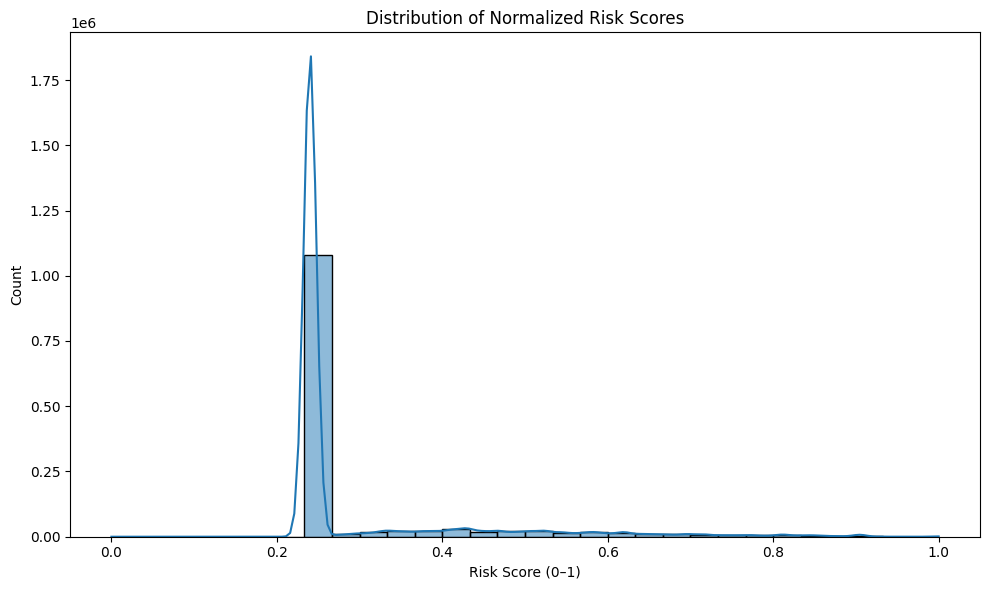

In [78]:
plt.figure(figsize=(10, 6))
sns.histplot(metrics_df['Risk_Score_Normalized'], bins=30, kde=True)
plt.title('Distribution of Normalized Risk Scores')
plt.xlabel('Risk Score (0–1)')
plt.tight_layout()
plt.savefig("../outputs/ Normalized_Risk_Scores.png", dpi=300)
plt.show()


In [36]:
# Ensure ARPU exists in metrics_df before further KPI calculations
if 'ARPU' not in metrics_df.columns:
    print("Merging ARPU into metrics_df again...")
    metrics_df = metrics_df.merge(
        arpu_df[['customer_id', 'ARPU']],
        on='customer_id',
        how='left'
    )


Merging ARPU into metrics_df again...


In [37]:
#Churn Probability
metrics_df[['ECL', 'LGD', 'ARPU']] = metrics_df[['ECL', 'LGD', 'ARPU']].fillna(0)

metrics_df['Churn_Probability'] = (
    0.4 * metrics_df['loan_default'] +
    0.3 * metrics_df['LGD'] +
    0.2 * (1 - metrics_df['ARPU'] / (metrics_df['ARPU'].max() + 1)) +  # Inverse ARPU
    0.1 * (1 - metrics_df['term'] / metrics_df['term'].max())          # Near end of term
)

metrics_df['Churn_Probability'] = metrics_df['Churn_Probability'].clip(0, 1)


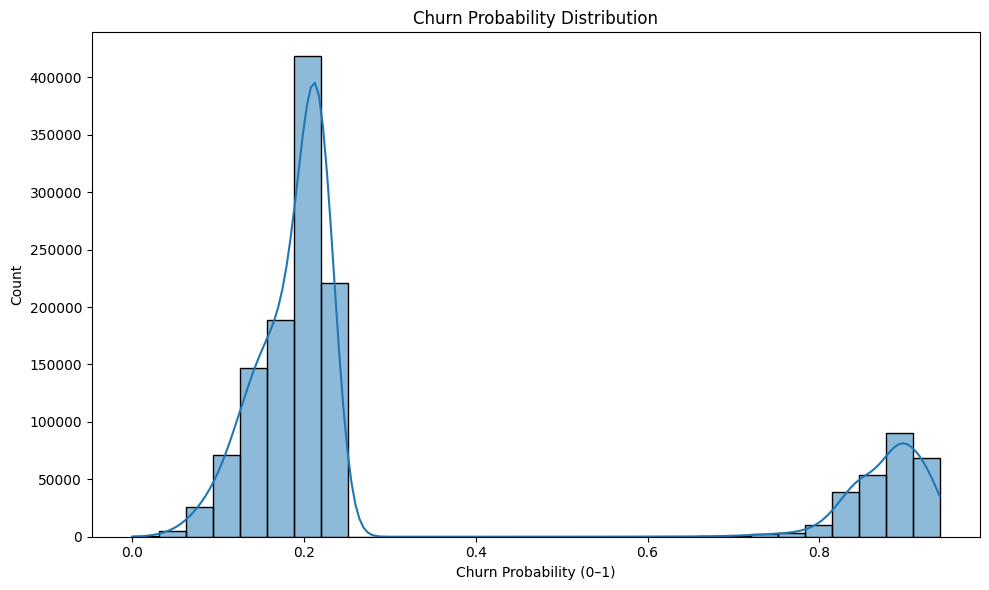

In [79]:
plt.figure(figsize=(10, 6))
sns.histplot(metrics_df['Churn_Probability'], kde=True, bins=30)
plt.title("Churn Probability Distribution")
plt.xlabel("Churn Probability (0–1)")
plt.tight_layout()
plt.savefig("../outputs/Churn_probability.png", dpi=300)
plt.show()


In [39]:
def classify_risk(prob):
    if prob >= 0.7:
        return 'High Risk'
    elif prob >= 0.4:
        return 'Medium Risk'
    else:
        return 'Low Risk'

metrics_df['Risk_Segment'] = metrics_df['Churn_Probability'].apply(classify_risk)


In [40]:
# Handle missing CLTV
metrics_df['CLTV'] = metrics_df['CLTV'].fillna(0)

# Use quantiles to separate customers into value tiers
cltv_75 = metrics_df['CLTV'].quantile(0.75)
cltv_25 = metrics_df['CLTV'].quantile(0.25)

def classify_value(cltv):
    if cltv >= cltv_75:
        return 'High Value'
    elif cltv >= cltv_25:
        return 'Medium Value'
    else:
        return 'Low Value'

metrics_df['Value_Segment'] = metrics_df['CLTV'].apply(classify_value)


In [41]:
metrics_df['Segment'] = metrics_df['Risk_Segment'] + ' - ' + metrics_df['Value_Segment']


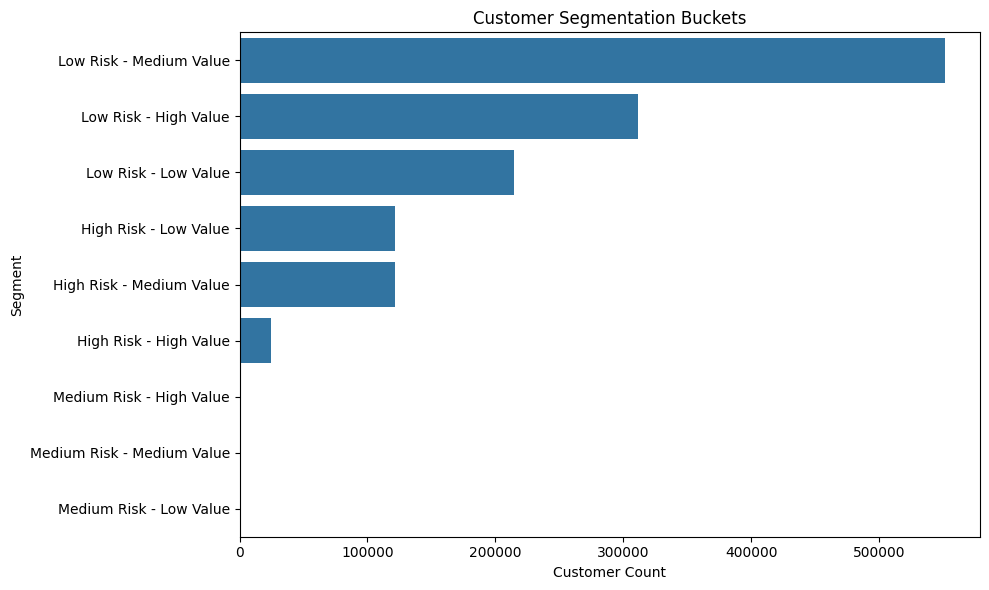

In [80]:
plt.figure(figsize=(10,6))
sns.countplot(data=metrics_df, y='Segment', order=metrics_df['Segment'].value_counts().index)
plt.title("Customer Segmentation Buckets")
plt.xlabel("Customer Count")
plt.ylabel("Segment")
plt.tight_layout()
plt.tight_layout()
plt.savefig("../outputs/customer_segmentation_buckets", dpi=300)
plt.show()


In [43]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
filename = f"FinSurf_KPI_Scorecard_{timestamp}.csv"
metrics_df.to_csv(filename, index=False)

print(f"Exported to '{filename}'")


Exported to 'FinSurf_KPI_Scorecard_20250723_1802.csv'


In [44]:
loan_data_df['issue_d'] = pd.to_datetime(loan_data_df['issue_d'], format='%b-%Y', errors='coerce')


In [45]:
loan_data_df['issue_month'] = loan_data_df['issue_d'].dt.to_period('M')


In [46]:
#Probability of Default (PD) over time
# Group by month and calculate PD = % of loans defaulted that month
monthly_pd = (
    loan_data_df.groupby('issue_month')['loan_default']
    .mean()
    .reset_index()
    .rename(columns={'loan_default': 'PD'})
)


In [47]:
# LGD (Loss Given Default) over time
# Only consider defaulted loans
defaulted = loan_data_df[loan_data_df['loan_default'] == 1]

monthly_lgd = (
    defaulted.groupby('issue_month')['LGD']
    .mean()
    .reset_index()
    .rename(columns={'LGD': 'LGD_avg'})
)


In [48]:
#ECL (Expected Credit Loss) over time
monthly_ecl = (
    loan_data_df.groupby('issue_month')['ECL']
    .mean()
    .reset_index()
    .rename(columns={'ECL': 'ECL_avg'})
)


In [49]:
#Join all KPI trends into one
kpi_trends = monthly_pd.merge(monthly_lgd, on='issue_month', how='outer')
kpi_trends = kpi_trends.merge(monthly_ecl, on='issue_month', how='outer')


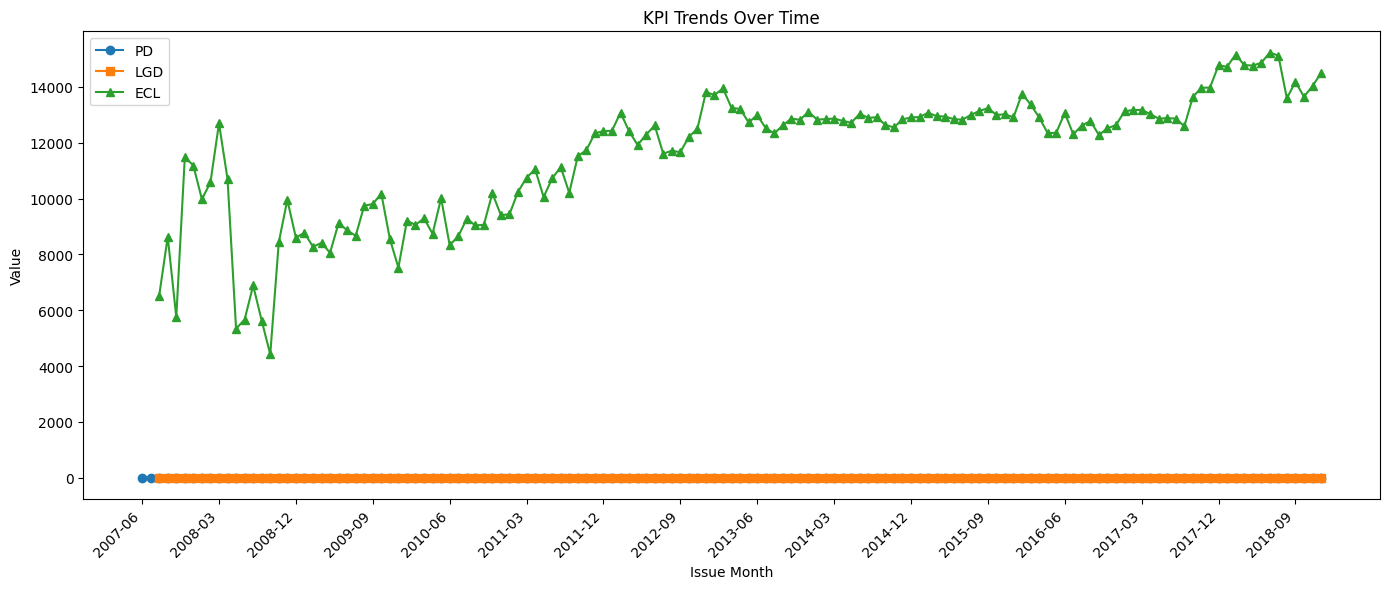

In [81]:
#Visualize over time
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot
plt.plot(kpi_trends['issue_month'].astype(str), kpi_trends['PD'], label='PD', marker='o')
plt.plot(kpi_trends['issue_month'].astype(str), kpi_trends['LGD_avg'], label='LGD', marker='s')
plt.plot(kpi_trends['issue_month'].astype(str), kpi_trends['ECL_avg'], label='ECL', marker='^')

# Title and labels
plt.title('KPI Trends Over Time')
plt.xlabel('Issue Month')
plt.ylabel('Value')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Display fewer x-axis ticks for clarity
tick_frequency = max(1, len(kpi_trends) // 15)
plt.xticks(ticks=range(0, len(kpi_trends), tick_frequency), 
           labels=kpi_trends['issue_month'].astype(str)[::tick_frequency], rotation=45, ha='right')

plt.legend()
plt.tight_layout()
plt.tight_layout()
plt.savefig("../outputs/kpi_trends_overtime.png", dpi=300)
plt.show()



In [51]:
loan_data_df['issue_d'] = pd.to_datetime(loan_data_df['issue_d'], errors='coerce')
loan_data_df['cohort_month'] = loan_data_df['issue_d'].dt.to_period('M')
metrics_df = metrics_df.merge(loan_data_df[['customer_id', 'cohort_month']], on='customer_id', how='left')


In [52]:
# Convert issue_d to datetime (you already did this)
loan_data_df['issue_d'] = pd.to_datetime(loan_data_df['issue_d'], errors='coerce')

# Create cohort_month as period type
loan_data_df['cohort_month'] = loan_data_df['issue_d'].dt.to_period('M')


In [53]:
metrics_df = metrics_df.merge(
    loan_data_df[['customer_id', 'cohort_month']],
    on='customer_id',
    how='left'
)


In [54]:
print(metrics_df.columns)


Index(['customer_id', 'LGD', 'ECL', 'ARPU_x', 'term', 'CLTV', 'ARPU_y',
       'customer_tenure', 'loan_default', 'Risk_Score',
       'Risk_Score_Normalized', 'ARPU', 'Churn_Probability', 'Risk_Segment',
       'Value_Segment', 'Segment', 'cohort_month_x', 'cohort_month_y'],
      dtype='object')


In [55]:
if 'default_probability' in loan_data_df.columns:
    metrics_df = metrics_df.merge(
        loan_data_df[['customer_id', 'default_probability']],
        on='customer_id',
        how='left'
    )
    metrics_df.rename(columns={'default_probability': 'PD'}, inplace=True)


In [56]:
if 'cohort_month' in metrics_df.columns:
    metrics_df['cohort_month'] = metrics_df['cohort_month'].astype(str)


In [57]:
# Drop existing cohort_month from metrics_df if it already exists
if 'cohort_month' in metrics_df.columns:
    metrics_df.drop(columns=['cohort_month'], inplace=True)

if 'cohort_month' in loan_data_df.columns:
    metrics_df = metrics_df.merge(
        loan_data_df[['customer_id', 'cohort_month']],
        on='customer_id',
        how='left'
    )


In [58]:
# Convert cohort_month to datetime if it's Period type
if pd.api.types.is_period_dtype(metrics_df['cohort_month']):
    metrics_df['cohort_month'] = metrics_df['cohort_month'].dt.to_timestamp()


C:\Users\mahas\AppData\Local\Temp\ipykernel_4936\1112112212.py:2: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(metrics_df['cohort_month']):


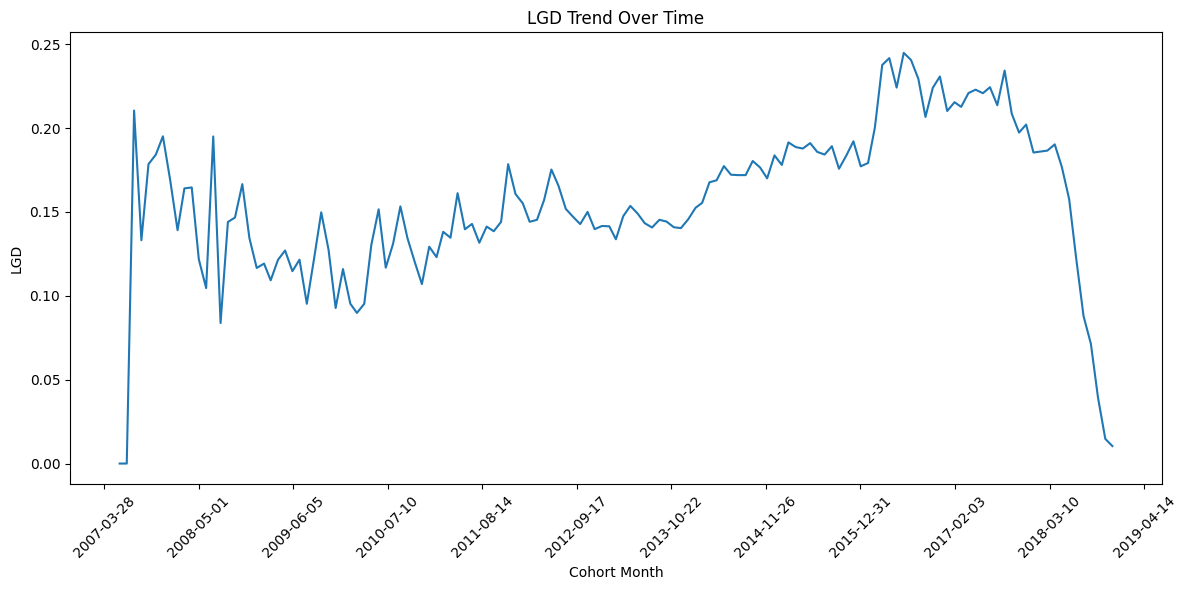

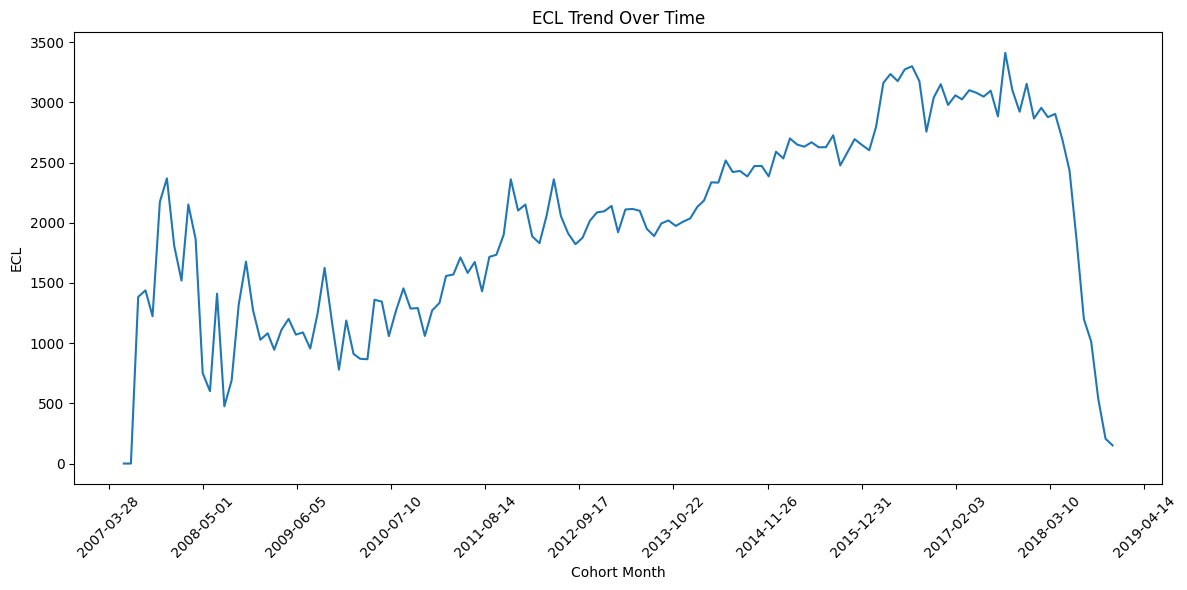

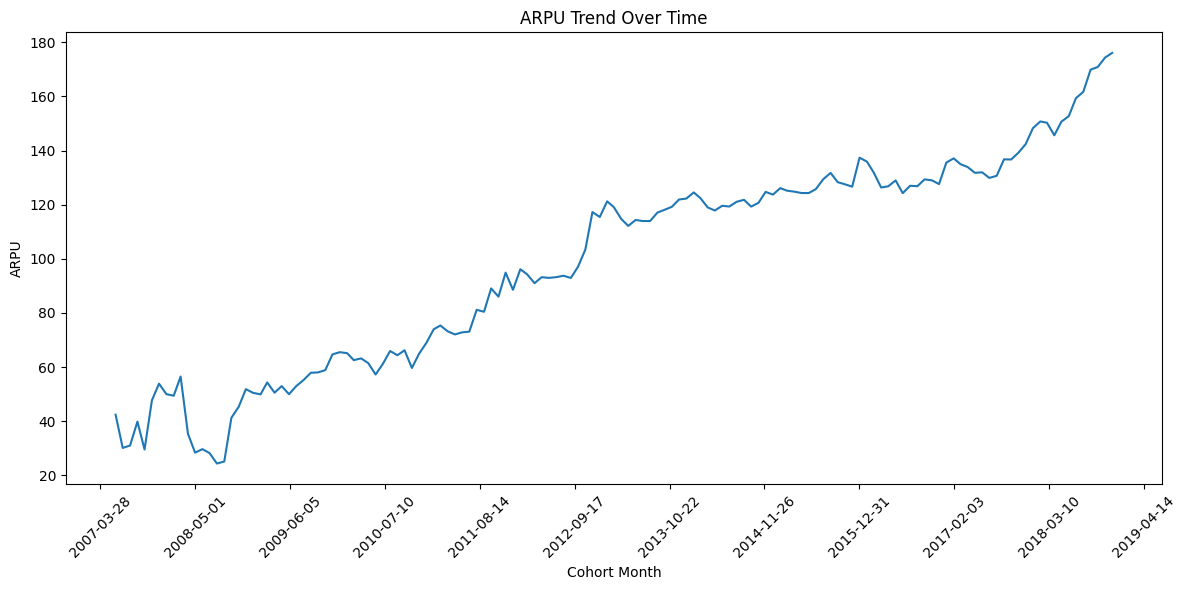

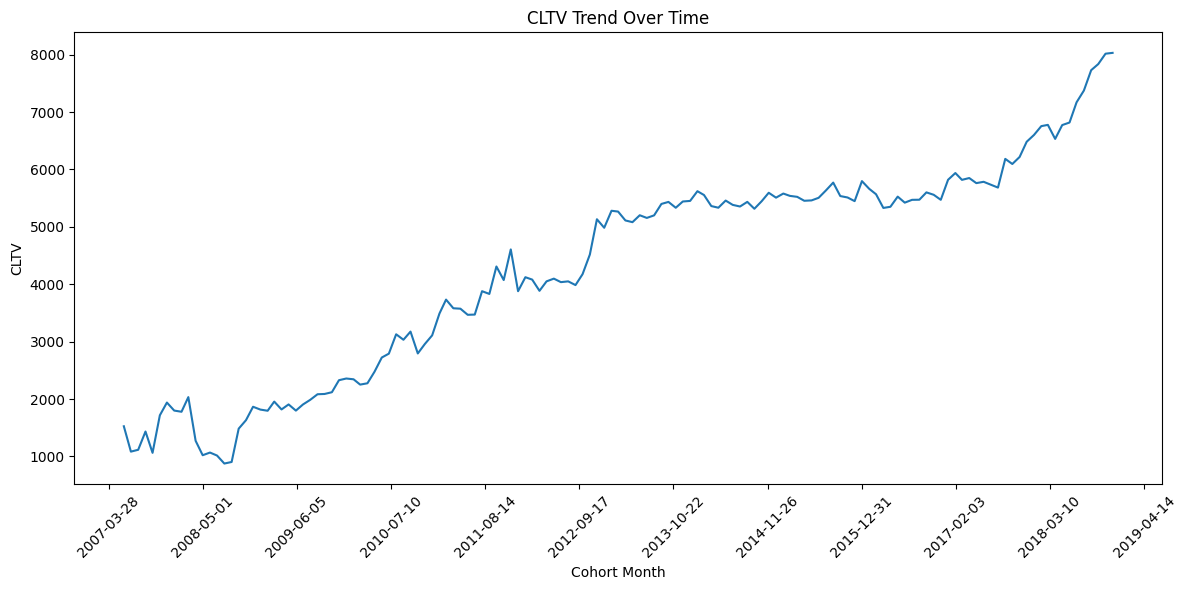

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
# Ensure proper datetime format
metrics_df['cohort_month'] = pd.to_datetime(metrics_df['cohort_month'])

# Sort by date
metrics_df = metrics_df.sort_values('cohort_month')

# Plot KPIs
kpis = ['LGD', 'ECL', 'ARPU', 'CLTV']

for kpi in kpis:
    if kpi in metrics_df.columns:
        trend = metrics_df.groupby('cohort_month')[kpi].mean().reset_index()
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=trend, x='cohort_month', y=kpi)
        plt.title(f'{kpi} Trend Over Time')
        plt.xlabel('Cohort Month')
        plt.ylabel(kpi)
        plt.xticks(rotation=45)
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))  # Show max 12 labels
        plt.tight_layout()
        plt.savefig(f"../outputs/kpi_trends/{kpi.lower()}_trend_over_time.png", dpi=300)
        plt.show()


In [60]:
print("Shape:", metrics_df.shape)
print("Columns:\n", metrics_df.columns.tolist())


Shape: (1345350, 20)
Columns:
 ['customer_id', 'LGD', 'ECL', 'ARPU_x', 'term', 'CLTV', 'ARPU_y', 'customer_tenure', 'loan_default', 'Risk_Score', 'Risk_Score_Normalized', 'ARPU', 'Churn_Probability', 'Risk_Segment', 'Value_Segment', 'Segment', 'cohort_month_x', 'cohort_month_y', 'PD', 'cohort_month']


In [61]:
metrics_df = metrics_df.drop(columns=['ARPU_x', 'ARPU_y'], errors='ignore')
metrics_df = metrics_df.drop(columns=['term_x', 'term_y', 'cohort_month_x', 'cohort_month_y'], errors='ignore')


In [62]:
print("CLTV stats:\n", metrics_df['CLTV'].describe())
print("Top CLTV records:")
display(metrics_df[['customer_id', 'ARPU', 'term', 'CLTV']].sort_values(by='CLTV', ascending=False).head())


CLTV stats:
 count    1.345350e+06
mean     5.474438e+03
std      4.693148e+03
min      0.000000e+00
25%      2.173283e+03
50%      3.914165e+03
75%      7.362283e+03
max      3.613495e+04
Name: CLTV, dtype: float64
Top CLTV records:


,customer_id,ARPU,term,CLTV
424066,424067,602.249239,60.0,36134.954320
978623,978624,598.057103,60.0,35883.426159
433100,433101,595.094035,60.0,35705.642089
533226,533227,583.972221,60.0,35038.333288
549679,549680,583.535746,60.0,35012.144739


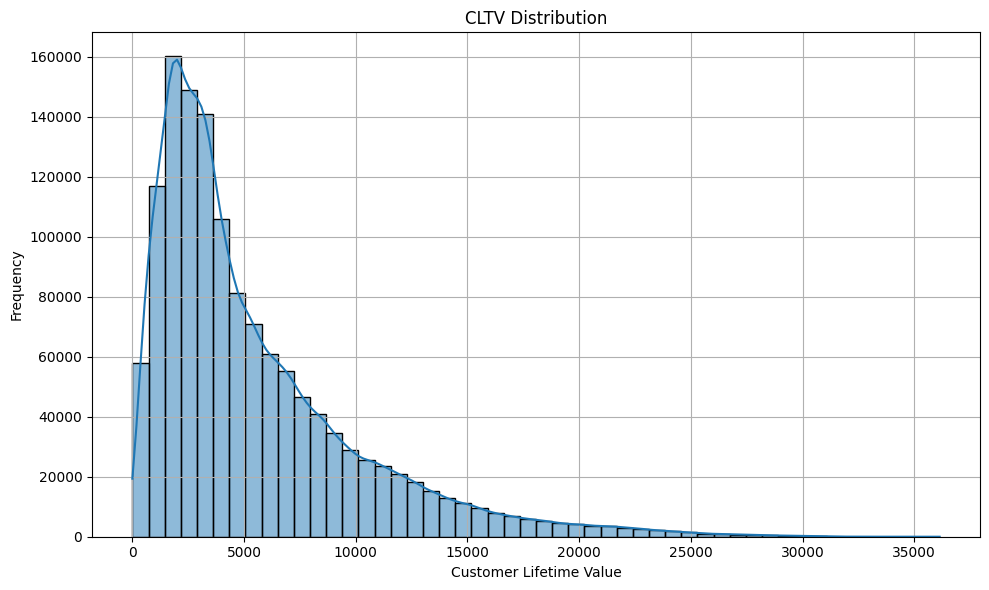

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(metrics_df['CLTV'], bins=50, kde=True)
plt.title('CLTV Distribution')
plt.xlabel('Customer Lifetime Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.savefig("../outputs/cltv_distribution.png", dpi=300)
plt.show()


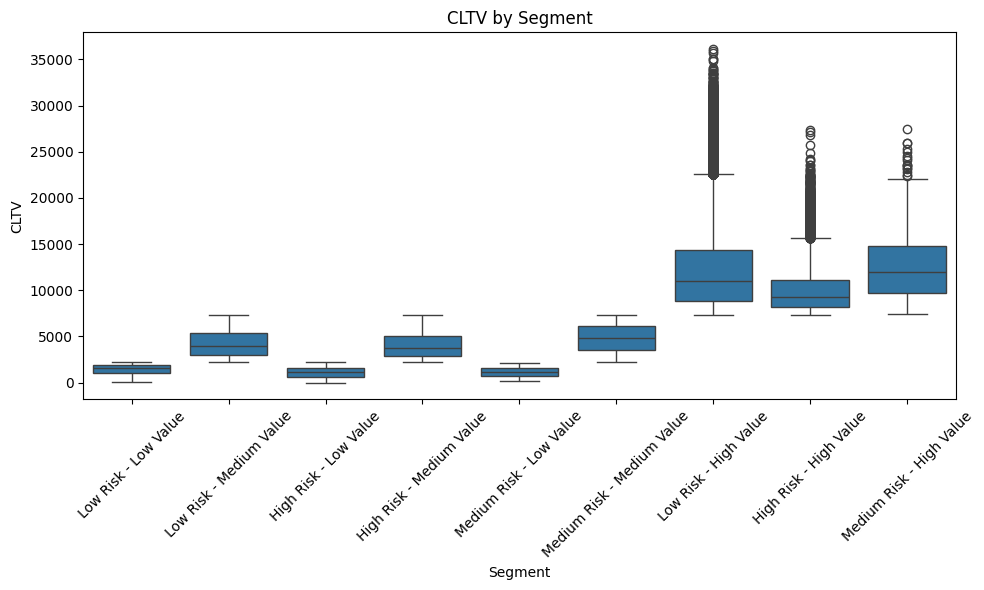

In [84]:
plt.figure(figsize=(10,6))
sns.boxplot(data=metrics_df, x='Segment', y='CLTV')
plt.title('CLTV by Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../outputs/cltv_Segment.png", dpi=300)
plt.show()


In [65]:
metrics_df.to_csv("../outputs/metrics_df_final.csv", index=False)
print("Final metrics_df saved.")


Final metrics_df saved.
